# Сборный проект —2

## Задание

Заказчик - HR-аналитики компании «Работа с заботой». Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.


Требуется выполнить 2 задачи:
* Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
* Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Задача №1 предсказание уровня удовлетворённости сотрудника

### План работы

* Изучение предоставленных данных


* Загрузка данных в датасеты


* Предобработка данных (чать работы в пайплайне)
    * Исправление названий столбцов
    * Приведение написания данных к единому стандарту
    * Заполнение пропусков
    * Удаление дубликатов
    * Изменение типов данных
    
    
* Исследовательский анализ данных
    * Поиск и удаление выбросов
    * Изучение распределения данных


* Подготовка данных (часть работы в пайлайне)


* Обучение модели


* Выводы по задаче №1 для заказчика

### Данные

* **id** — уникальный идентификатор сотрудника;
* **dept** — отдел, в котором работает сотрудник;
* **level** — уровень занимаемой должности;
* **workload** — уровень загруженности сотрудника;
* **employment_years** — длительность работы в компании (в годах);
* **last_year_promo** — показывает, было ли повышение за последний год;
* **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
* **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
* **salary** — ежемесячная зарплата сотрудника;
* **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, целевой признак.

### Шаг 0. Загрузка необходимых библиотек и функций

import sys
!{sys.executable} -m pip install phik -q
import phik

!{sys.executable} -m pip install shap -q
import shap

!pip install -U scikit-learn -q

!pip install matplotlib==3.5.1 -q

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn

import phik
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
RANDOM_STATE = 42

**функции**

In [3]:
#Функция для вывода всех уникальных значений для каждого столбца датасета
#для поиска неявных дублей
def find_duplicate(dataset):
    for col in dataset:
        print(f'Список уникальных значений для {col}: {dataset[col].unique()}\nКоличество уникальных значений: {len(dataset[col].unique())}\n\n')

In [4]:
#Функция для вывода отдельно количественных столбцов и отдельно категоральных для последующего анализа

def analiz_cols(data):
    cat_col = data.select_dtypes(exclude=['number']).columns
    num_col = data.drop(['id'], axis=1).select_dtypes(include=['number']).columns #Столбец id нам не нужен в боксплоте
    
    print('Категоральные столбцы: ','\n')
    for col in cat_col:
        print(col)
    print('\n')
    print('Количественные столбцы: ','\n')
    for col in num_col:
        print(col)

In [5]:
#Функция для исследовательского анализа количественных признаков. Строит диаграмму размаха,
#показывает список и количество выбросов, при их присутствии 

def num_col_analiz(data, col):
    sn.set_palette('Set2')
    plt.subplots(figsize=(10, 2))
    sn.boxplot(data=data[col], orient='h');
    plt.title(label = f'Диаграмма размаха для показателя {col}', fontsize=15)
    plt.show()
    extum_list_max=[] #Список для выбросов "справа"
    extum_list_min=[] #Список для выбросов "слева"
    Q3 = data[col].describe().loc['75%'] #Фиксируем значение третьего квартиля
    Q1 = data[col].describe().loc['25%'] #Фиксируем значение первого квартиля
    IQR = Q3-Q1  #Находим межквартильный размах
    for i in data[col]: #Находим экстремумные значения - "выбросы" и раскидываем их по спискам
        if i < (Q1 - IQR * 1.5):
            extum_list_min.append(i)
        if i > (Q3 + IQR * 1.5):
            extum_list_max.append(i)
    col_size = len(data[col])
    extum_list_min = sorted(extum_list_min)
    extum_list_max = sorted(extum_list_max)
    min_len = len(extum_list_min)
    max_len = len(extum_list_max)
    print(f'Выбросы ниже нормальных значений: {extum_list_min} \nКоличество выбросов: {min_len} \nПроцент выбросов: {round((min_len / col_size) * 100,2)} %')
    print('\n')
    print(f'Выбросы выше нормальных значений: {extum_list_max} \nКоличество выбросов: {max_len} \nПроцент выбросов: {round((max_len / col_size) * 100,2)} %')
    print('\n')
    print(data[col].describe().T)
    print('\n')

In [6]:
#Функция для анализа категоральных столбцов. Строит гистограмму и выводит отношение значений (без учета np.nan)

def cat_col_analiz(data, col, val_show='on', hue='off', discrete=False, common_norm=False):
    sn.set_palette('Set2')
    plt.subplots(figsize=(12, 6))
    if hue=='off':
        sn.histplot(data.dropna(), x=col)
    if hue != 'off':
        sn.histplot(data.dropna(), x=col, hue=hue, multiple='stack', discrete=discrete, common_norm=common_norm)
    plt.title(label = f'Гистограмма для показателя {col}\nБез учета значений np.nan\n', fontsize=15)
    plt.xlabel(col, fontsize=15)
    plt.xticks(rotation=45,fontsize=10)
    plt.ylabel('Количество', fontsize=15)
    plt.show()
    if val_show == 'on':
        print(f'{data[col].value_counts(normalize=True)}\n{data[col].value_counts()}')
    print('\n')

In [7]:
def smape_metric(y_pred, y_test):    
    num = abs(y_pred - y_test)
    denom = (abs(y_test) + abs(y_pred)) / 2
    
    # Проверка на нулевой знаменатель
    denom[denom == 0] = 1e-10
    smape_value = np.mean(num / denom) * 100
    return smape_value

In [8]:
SMAPE = make_scorer(smape_metric, greater_is_better=False)

### Шаг 1. Загрузка данных

In [9]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

Проверим что все данные считались корректно

In [10]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Столбцы датасета **train_job_satisfaction_rate** корректно названы, данные загружены корректно.

**------------------------------------------**

**------------------------------------------**

In [11]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Столбцы датасета **test_features** корректно названы, данные загружены корректно.

**------------------------------------------**

**------------------------------------------**

In [12]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Столбцы датасета **test_target_job_satisfaction_rate** корректно названы, данные загружены корректно.

**Все данные считались корректно**

### Шаг 2. Предобработка данных

In [13]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [14]:
train_job_satisfaction_rate.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [15]:
find_duplicate(train_job_satisfaction_rate.drop('id', axis=1))

Список уникальных значений для dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Количество уникальных значений: 6


Список уникальных значений для level: ['junior' 'middle' 'sinior' nan]
Количество уникальных значений: 4


Список уникальных значений для workload: ['medium' 'high' 'low']
Количество уникальных значений: 3


Список уникальных значений для employment_years: [ 2  1  4  7  9  6  3 10  8  5]
Количество уникальных значений: 10


Список уникальных значений для last_year_promo: ['no' 'yes']
Количество уникальных значений: 2


Список уникальных значений для last_year_violations: ['no' 'yes']
Количество уникальных значений: 2


Список уникальных значений для supervisor_evaluation: [1 5 2 3 4]
Количество уникальных значений: 5


Список уникальных значений для salary: [24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 624

В стобцах **dept** и **level** имеется 6 и 4 значения **nan** соответственно, их мы будем обрабатывать по заданию в пайплайне. Неявных дублей нет. Проверим на явные дубли.

In [16]:
train_job_satisfaction_rate.duplicated().sum()

0

Полных дубликатов нет

**------------------------------------------**

In [17]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [18]:
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [19]:
find_duplicate(test_features.drop('id', axis=1))

Список уникальных значений для dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Количество уникальных значений: 7


Список уникальных значений для level: ['junior' 'middle' 'sinior' nan]
Количество уникальных значений: 4


Список уникальных значений для workload: ['medium' 'low' 'high' ' ']
Количество уникальных значений: 4


Список уникальных значений для employment_years: [ 2  1  5  6  3  9  7  4  8 10]
Количество уникальных значений: 10


Список уникальных значений для last_year_promo: ['no' 'yes']
Количество уникальных значений: 2


Список уникальных значений для last_year_violations: ['no' 'yes']
Количество уникальных значений: 2


Список уникальных значений для supervisor_evaluation: [5 4 3 1 2]
Количество уникальных значений: 5


Список уникальных значений для salary: [28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 2

В стобцах **dept** и **level** имеется 2 и 1 значения **nan** соответственно, а так же в столбцах **workload** и **debt** имеется значение " "(пустое), " " мы обработаем сейчас, чтобы избежать проблем в пайплайне с **SimpleImputer**

In [20]:
test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

Проверим

In [21]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [22]:
test_features['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

**Поправили**

In [23]:
test_features.duplicated().sum()

0

Полных дубликатов нет

**------------------------------------------**

In [24]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [25]:
test_target_job_satisfaction_rate.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

Пропусков нет

In [26]:
test_target_job_satisfaction_rate.duplicated().sum()

0

Полных дубликатов нет

**------------------------------------------**

Так как столбцы **"id"** содержат уникальные значения, которые не участвуют в обучении модели, то лучше перевести их в индексы, однако это будет сделано позже, на этапе подготовки данных. 

_P.S можно было бы сделать и сейчас, но без "id" как второго столбца в датасете **test_target_job_satisfaction_rate** при построении боксплота вываливается ошибка, которую быстро не смог побороть, поэтому отложил индексирование ID на этап после исследовательского анализа данных._

**_Так же, я вкурсе, что при удалении "id" как признака, в датасетах появляется много явных дубликатов. Я не стал их чистить и акцентировать внимание в исследовательском анализе на этом, поясню почему, представим 2 примера:_**

_**Пример 1.**  У нас есть в компании условно новый отдел, собранный с нуля. В нем работает 10 человек. Из них одного зовут Коля, а 9 других зовут Вася, но у всех у них разные фамилии, т.е 9 РАЗНЫХ Вась_

_У этих 10 человек одинаковая должность, одинаковый размер оклада, т.к отдел новый, у них одинаковый стаж работы и одинаковое количество лет без повышения, так же как новые сотрудники, они бояться нарушать правила трудового распорядка, следовательно и количество нарушений у них одинаковое - 0, и т.д и т.п_

_Так как отдел сплоченный, коллеги часто обсуждают и обмениваются своим мнением по поводу условий труда, начальства и тд, и как такое часто бывает, у них одно мнение на всех по поводу их оценки удовлетворенности работодателем, тем более, что у них у всех одинаковые условия труда, и так получилось что все довольны._

_Но, Коля оказался более привередливым, и он единственный из отдела не очень доволен своими условиями_

_При подготовке модели, мы удалили столбец с ID сотрудников или их ФИО, в связи с чем мы получили 1 уникального обезличенного Колю, и 9 обезличенных "задублированных Вась". У всех 10 записей все входящие признаки одинаковы, об этом мы договорились выше, отличается только удовлетворенность работой. Все Васи довольны, а Коля нет. И следуя правилу "удаляй дубликаты", не вдумываясь в обьективную сущность данных, мы удалим 8 Васей как дубликаты некого одного Васи. И получим всего 2 записи, 1 представитель от Васей, и 1 Коля. И машина, обманутая нами, предположит, что при совокупности входящих признаков, целейвой признак "удовлетворенность работой" будет иметь вероятность 50\50 доволен\нет_


_Но мы понимаем, что это ошибка, так у фактически, у нас в отделе было 10 человек, 9 довольны и 1 нет. И с их одинаковыми входящими признаками условно вероятности бы распределились иначе 90\10_

_По этой причине, имея изначально подсказку в виду уникальных "id", опущенную при обучении модели, мы понимаем, что те "явные дубли" которые обнаружились после удаления "id" из признаков, это **ложно положительные дубли**, которые на самом деле являются не повторной записью одного единственного сотрудника, а являются массой фактически уникальных сотрудников, но с одинаковыми входящими признаками. И во избежание обмана модели, как пример, приведенного выше, все эти дубли, я считаю, необходимо оставить_


_**Пример 2** если развить тему, можно предположить и такое, что каждый раз удаляя какой либо признак, который оказывает ничтожно малый вклад в выводы модели, мы будем размывать разницу между все бОльшим и бОльшим количеством сотрудников, которые при удалении признаков начнут становиться "дубликатами" друг друга, пока из 4000 записей в данном задании не останется 40 "действительно уникальных человек"_

#### Промежуточный итог по Предобработке данных

Во всех трех датасетах нет явных и неявных дублей. Названия столбцов и значения имеют стандартизированное написание. 
Присутствует несколько пропусков в некоторых столбах, которые будут обработаны в пайплайне. Строчные пропуски были заранее обработаны и заменены на значение np.nan. Столбцы **"id"** будут переведены в индексы позже.

### Шаг 3. Исследовательский анализ данных

У нас есть 3 датасета
* Обучающий **train_job_satisfaction_rate**, который необходимо разделить, в данном случае, на 2 части: 
    * **X_train** и **y_train** 
* Тестовый с входящими признаками или "X_test" - **test_features**
* Тестовый с целевым признаком или "y_test" - **test_target_job_satisfaction_rate**

In [27]:
test_features.shape

(2000, 9)

In [28]:
test_target_job_satisfaction_rate.shape

(2000, 2)

Как мы видим, предоставленные заказчиком "X_test" и "y_test" имеют одинаковое количество строк. Ок

Проведем исследовательский аналих предоставленных данных. Начнем с маленьких датасетов

#### 3.1 Исследовательский анализ test_target_job_satisfaction_rate

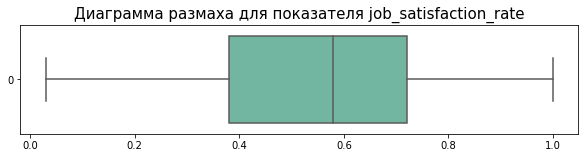

Выбросы ниже нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


Выбросы выше нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64




In [29]:
num_col_analiz(test_target_job_satisfaction_rate, 'job_satisfaction_rate')

**Выбросов нет, все значения укладываются в диапазон 0:1** 

**------------------------------------------**

#### 3.2 Исследовательский анализ test_features

In [30]:
analiz_cols(test_features)

Категоральные столбцы:  

dept
level
workload
last_year_promo
last_year_violations


Количественные столбцы:  

employment_years
supervisor_evaluation
salary


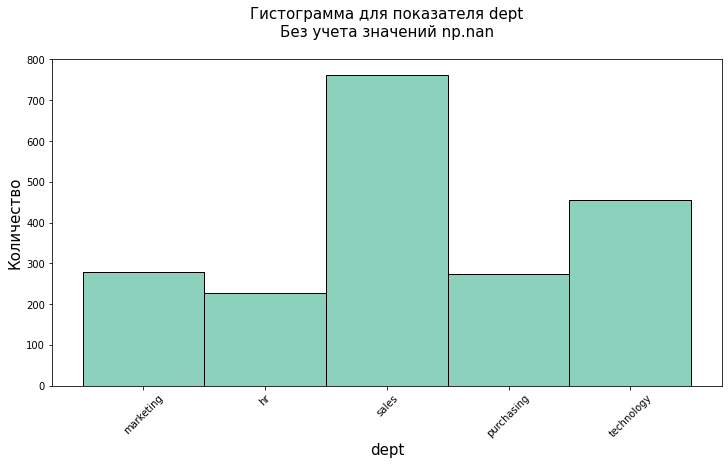

sales         0.382073
technology    0.227842
marketing     0.139710
purchasing    0.136705
hr            0.113671
Name: dept, dtype: float64
sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: dept, dtype: int64




In [31]:
cat_col_analiz(test_features, 'dept')

Больше всего сотрудников в отделе продаж, на втором месте технологический отдел.

**-------------------------------------------**

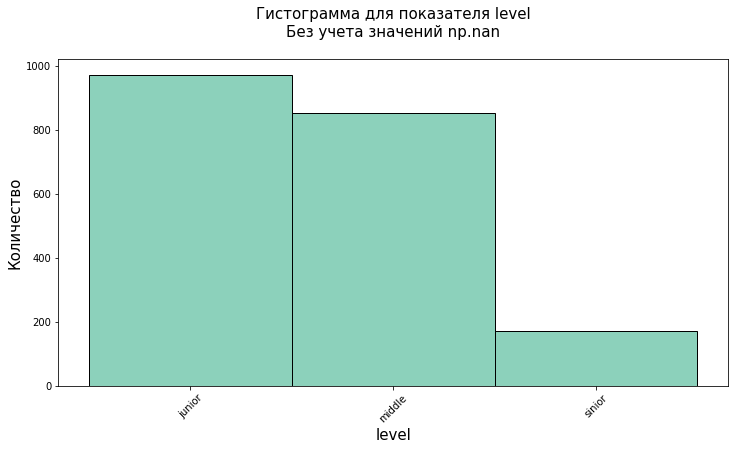

junior    0.487244
middle    0.427214
sinior    0.085543
Name: level, dtype: float64
junior    974
middle    854
sinior    171
Name: level, dtype: int64




In [32]:
cat_col_analiz(test_features, 'level')

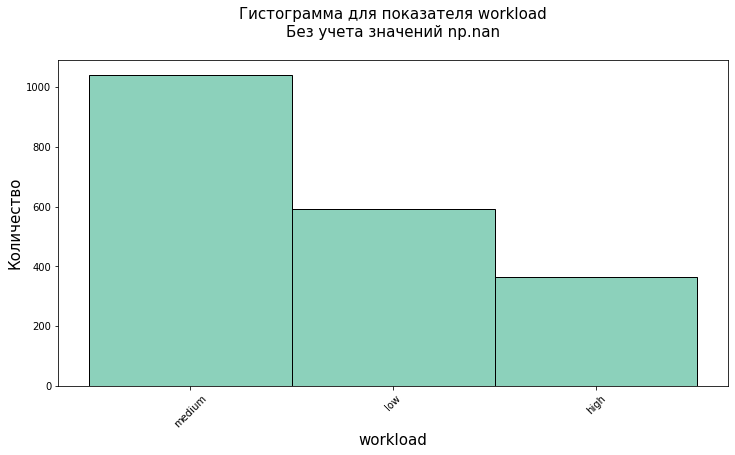

medium    0.521761
low       0.296648
high      0.181591
Name: workload, dtype: float64
medium    1043
low        593
high       363
Name: workload, dtype: int64




In [33]:
cat_col_analiz(test_features, 'workload')

У большинства сотрудников 52% средняя рабочая нагрузка.

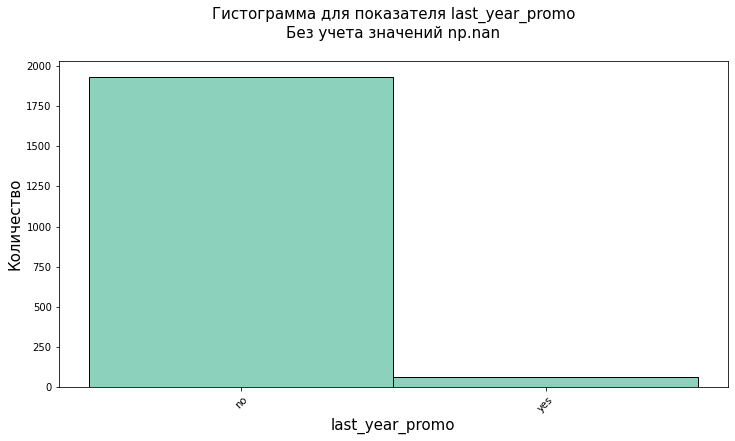

no     0.9685
yes    0.0315
Name: last_year_promo, dtype: float64
no     1937
yes      63
Name: last_year_promo, dtype: int64




In [34]:
cat_col_analiz(test_features, 'last_year_promo')

Повышают очень редко:)

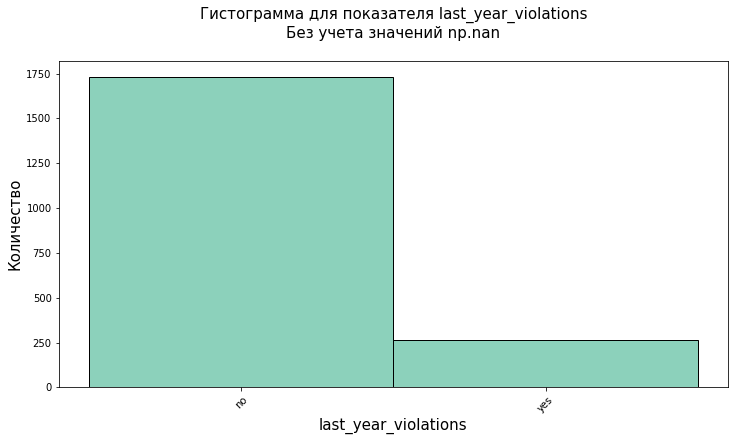

no     0.869
yes    0.131
Name: last_year_violations, dtype: float64
no     1738
yes     262
Name: last_year_violations, dtype: int64




In [35]:
cat_col_analiz(test_features, 'last_year_violations')

13% сотрудников ща последний год допускали нарушения трубового договора.

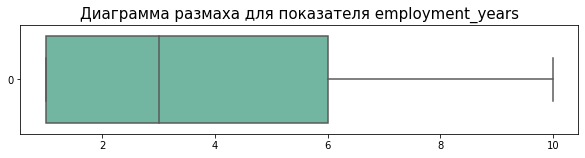

Выбросы ниже нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


Выбросы выше нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64




In [36]:
num_col_analiz(test_features, 'employment_years')

Медианный "возраст" сотрудника - 3 года. Самый "старый" сотрудник работает в компании уже 10 лет.
**Выбросов нет**

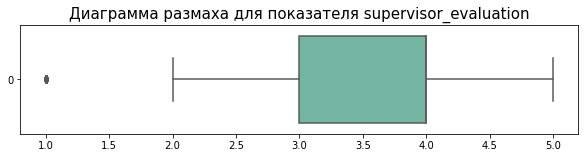

Выбросы ниже нормальных значений: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 
Количество выбросов: 88 
Процент выбросов: 4.4 %


Выбросы выше нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64




In [37]:
num_col_analiz(test_features, 'supervisor_evaluation')

Медианная оценка сотрудника равна 4. Работают хорошо:) Есть 88 выбросов с оценкой 1. Т.к по своей сути значение 1 не является в данном случае чем-то нелогичным или неподходящим, а вполне реальной возможной оценкой плохого сотрудника, **то эти "выбросы" мы оставляем.**

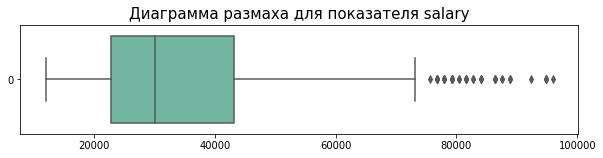

Выбросы ниже нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


Выбросы выше нормальных значений: [75600, 76800, 76800, 76800, 76800, 76800, 78000, 78000, 78000, 78000, 79200, 79200, 79200, 79200, 79200, 79200, 80400, 80400, 81600, 81600, 81600, 81600, 82800, 82800, 84000, 84000, 84000, 86400, 86400, 86400, 87600, 87600, 88800, 88800, 92400, 94800, 94800, 94800, 96000] 
Количество выбросов: 39 
Процент выбросов: 1.95 %


count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64




In [38]:
num_col_analiz(test_features, 'salary')

Медианная зарплата сотрудника равна 30.000. Присутствует 39 выбросов выше нормы, но абсолютные значения этих выбросов не являются какими то особенными. Это может быть зарплата Сеньеров, тем более, что гистограмма выше уже показала, что таких сотрудников меньшинство. **Эти "выбросы" мы оставляем**

**-------------------------------------------**

#### 3.3 Исследовательский анализ train_job_satisfaction_rate

In [39]:
analiz_cols(train_job_satisfaction_rate)

Категоральные столбцы:  

dept
level
workload
last_year_promo
last_year_violations


Количественные столбцы:  

employment_years
supervisor_evaluation
salary
job_satisfaction_rate


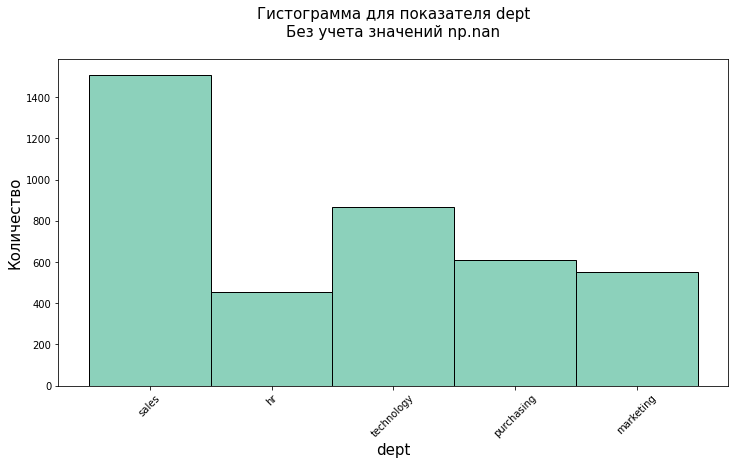

sales         0.378568
technology    0.216825
purchasing    0.152729
marketing     0.137707
hr            0.114171
Name: dept, dtype: float64
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64




In [40]:
cat_col_analiz(train_job_satisfaction_rate, 'dept')

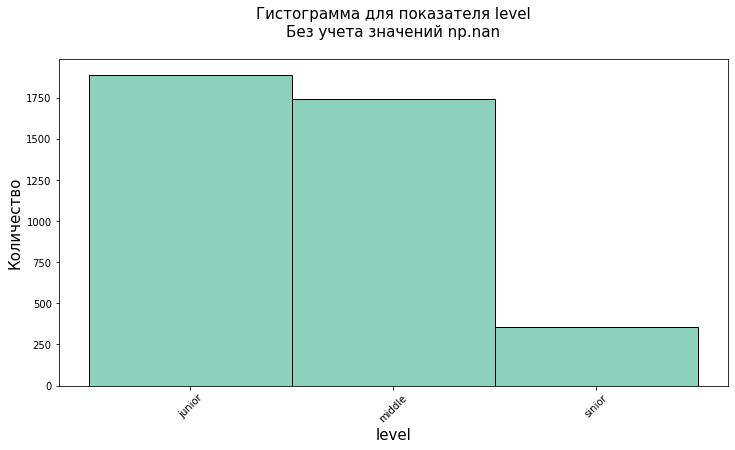

junior    0.473974
middle    0.436436
sinior    0.089590
Name: level, dtype: float64
junior    1894
middle    1744
sinior     358
Name: level, dtype: int64




In [41]:
cat_col_analiz(train_job_satisfaction_rate, 'level')

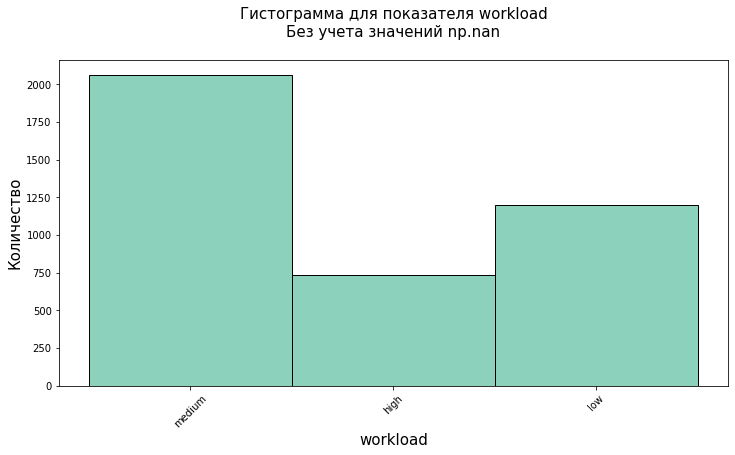

medium    0.5165
low       0.3000
high      0.1835
Name: workload, dtype: float64
medium    2066
low       1200
high       734
Name: workload, dtype: int64




In [42]:
cat_col_analiz(train_job_satisfaction_rate, 'workload')

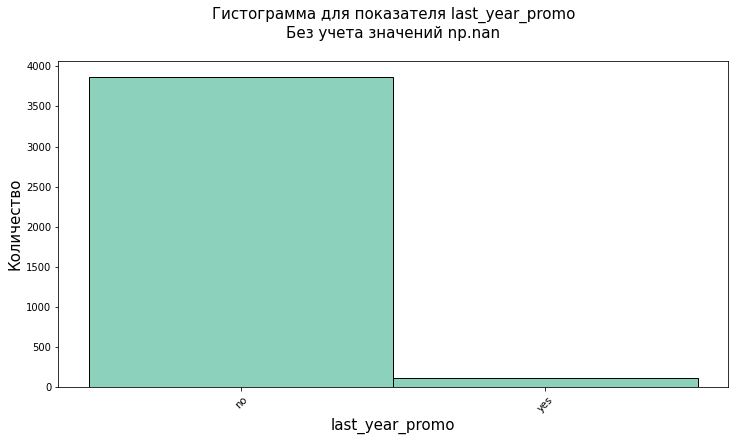

no     0.97
yes    0.03
Name: last_year_promo, dtype: float64
no     3880
yes     120
Name: last_year_promo, dtype: int64




In [43]:
cat_col_analiz(train_job_satisfaction_rate, 'last_year_promo')

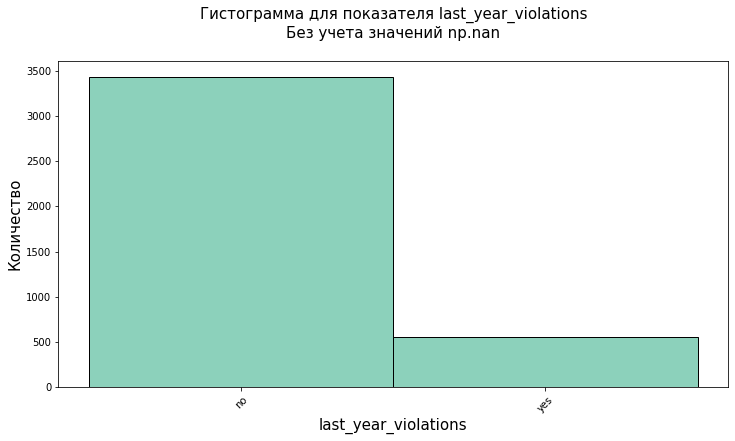

no     0.86025
yes    0.13975
Name: last_year_violations, dtype: float64
no     3441
yes     559
Name: last_year_violations, dtype: int64




In [44]:
cat_col_analiz(train_job_satisfaction_rate, 'last_year_violations')

По гистограммам категоральных признаков датасета **train_job_satisfaction_rate** можно утвержать, что распределение призаков в них очень близко или такое же как в категоральных признаках датасета **test_features**

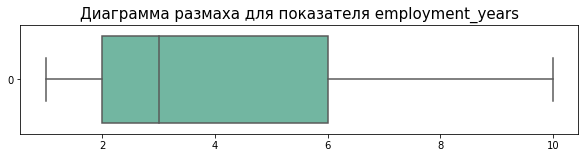

Выбросы ниже нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


Выбросы выше нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64




In [45]:
num_col_analiz(train_job_satisfaction_rate, 'employment_years')

Такой же размах как в соответствующем признаке датасета **test_features**

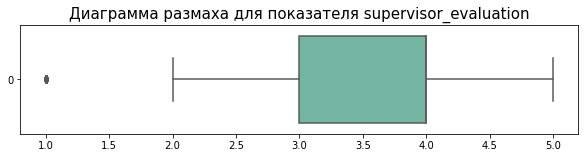

Выбросы ниже нормальных значений: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 
Количество выбросов: 201 
Процент выбросов: 5.03 %


Выбросы выше нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64




In [46]:
num_col_analiz(train_job_satisfaction_rate, 'supervisor_evaluation')

Такой же размах как в соответствующем признаке датасета **test_features**. Выводы такие же. "выбросы" оставляем

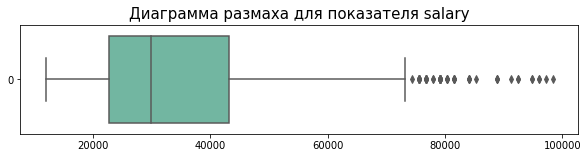

Выбросы ниже нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


Выбросы выше нормальных значений: [74400, 75600, 75600, 75600, 75600, 75600, 75600, 75600, 75600, 75600, 76800, 76800, 76800, 76800, 76800, 76800, 76800, 76800, 78000, 78000, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 80400, 80400, 80400, 80400, 81600, 81600, 81600, 81600, 81600, 84000, 84000, 84000, 84000, 85200, 88800, 88800, 88800, 91200, 92400, 92400, 94800, 94800, 96000, 96000, 97200, 98400] 
Количество выбросов: 60 
Процент выбросов: 1.5 %


count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64




In [47]:
num_col_analiz(train_job_satisfaction_rate, 'salary')

Такой же размах как в соответствующем признаке датасета **test_features**. Выводы такие же. "выбросы" оставляем

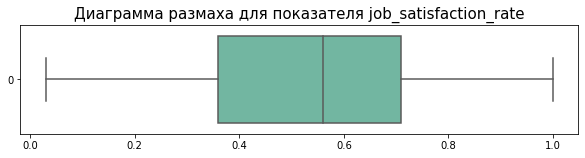

Выбросы ниже нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


Выбросы выше нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64




In [48]:
num_col_analiz(train_job_satisfaction_rate, 'job_satisfaction_rate')

Такой же размах как в соответствующем признаке датасета **test_target_job_satisfaction_rate**. Выводы такие же. Выбросов нет

In [49]:
intervals_cols = ['salary', 'job_satisfaction_rate']

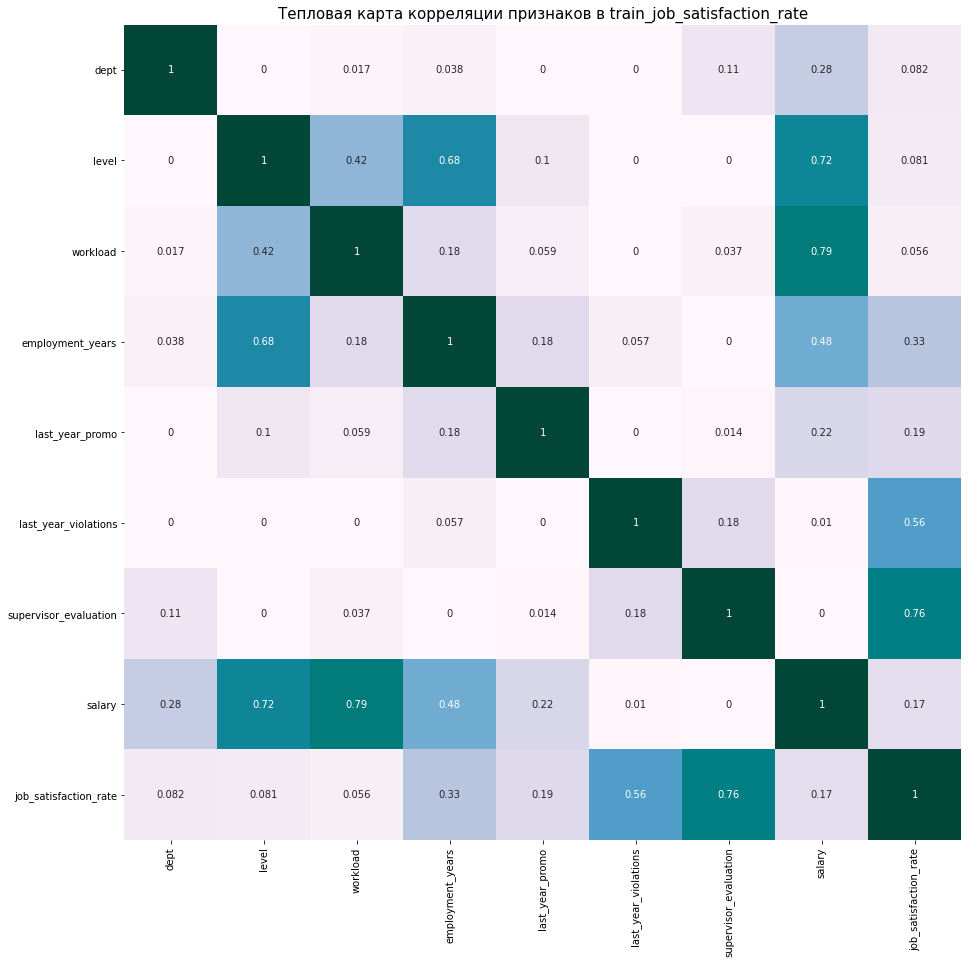

In [50]:
plt.subplots(figsize=(15, 15))
plt.title(label = 'Тепловая карта корреляции признаков в train_job_satisfaction_rate', fontsize=15)
sn.heatmap(train_job_satisfaction_rate.drop('id', axis=1).phik_matrix(interval_cols=intervals_cols), cmap="PuBuGn", cbar=False, annot=True);

In [51]:
intervals_cols_test = ['salary']

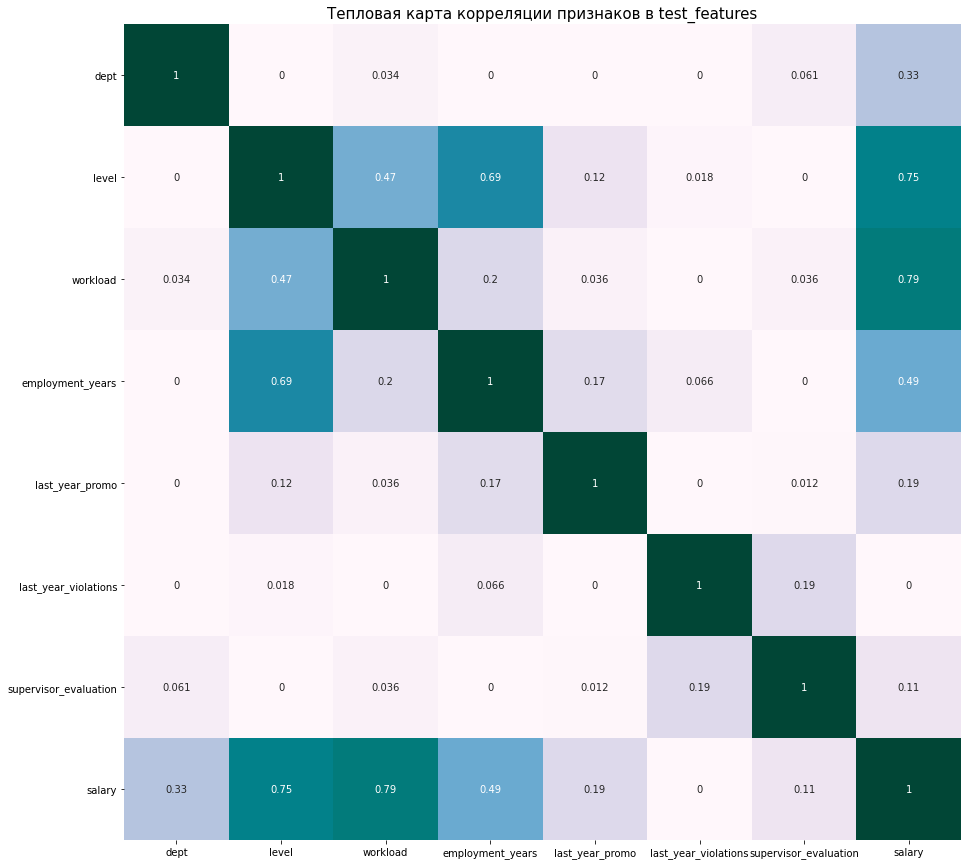

In [52]:
plt.subplots(figsize=(15, 15))
plt.title(label = 'Тепловая карта корреляции признаков в test_features', fontsize=15)
sn.heatmap(test_features.drop('id', axis=1).phik_matrix(interval_cols=intervals_cols), cmap="PuBuGn", cbar=False, annot=True);

**Мультиколинеарности не обнаружено**

#### Итоги по исследовательскому анализу

Данные были собраны аккуратно. Выбросов почти нет, а те, что присутствуют - не нарушают логическую сущность описываемых ими признаков. В связи с чем, все выбросы были оставлены в датасетах.
Во всех 3 рассмотренных датасетах одинаковое или близкое друг к другу распределение значений в соответвующих друг другу столбцах. Высокой мультиколлинеарности не обнаружено.


   Далее все количественные признаки будут отмасштабированы, а категоральные закодированы. Неранговые будут закодированы OneHotEncoder'ом, а ранговые, такие как **'level'**, **workload** - OrdEncoder'ом.

### Шаг 4. Подготовка данных

Так как столбцы **"id"** содержат уникальные значения, которые не участвуют в обучении модели, то лучше перевести их в индексы

In [53]:
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.set_index('id')
test_features = test_features.set_index('id')
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id')

Создадим списки количественных признаков, категоральных и ранговых. Т.к названия столбцов и их сущность едина для всех 3 датасетов, то создавать списки будем на базе самого "широкого" датасета из всех **train_job_satisfaction_rate**

In [54]:
train_job_satisfaction_rate.drop('job_satisfaction_rate', axis=1).columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary'],
      dtype='object')

In [55]:
ohe_col = ['dept', 'last_year_promo', 'last_year_violations']
ord_col = ['level', 'workload']
pass_col = ['supervisor_evaluation', 'employment_years'] #Признак без обработки
num_col = ['salary']

Списки готовы, приступаем к сборке пайплайна

Для удобства восприятия дадим нашим датасетам вторые названия, привычные для создания и настройки моделей:

In [56]:
X_test = test_features
y_test = test_target_job_satisfaction_rate

In [57]:
X_train = train_job_satisfaction_rate.drop('job_satisfaction_rate', axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

In [58]:
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [59]:
y_test.head()

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


Как мы видим, у предоставленных заказчиком **X_test** и **y_test** индексы идут в разнобой, изза этого модель не сможет корректно сделать предсказание. Отсортируем оба датасета в едином порядке, чтобы индексы стояли везде одинакого

In [60]:
X_test = X_test.sort_index()

In [61]:
y_test = y_test.sort_index()

In [62]:
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [63]:
y_test.head()

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


In [64]:
for col in ord_col:
    print(X_train[col].unique())

['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']


### Шаг 5. Обучение моделей

In [65]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', OneHotEncoder(handle_unknown='ignore', drop='first')
        )
    ]
)

In [66]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                handle_unknown='use_encoded_value',
                unknown_value=np.nan,
                categories=[
                    ['junior','middle','sinior'],
                    ['low','medium','high']
                ]
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [67]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('pas', 'passthrough', pass_col),
        ('num', StandardScaler(), num_col)
    ],
    remainder='passthrough'
)

In [68]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', None)
    ]
) 

In [69]:
param_grid = [
    {
        'models':[DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(10,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [70]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid,
    cv=10,
    scoring = SMAPE, 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)

In [71]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid,
    cv=10,
    scoring = SMAPE,
    n_jobs=-1
)

In [72]:
randomized_search.fit(X_train, y_train);

In [73]:
grid_search.fit(X_train, y_train);

In [74]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кроссвалидации:', abs(randomized_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

In [75]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на кроссвалидации:', abs(grid_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

Критерий успеха: SMAPE ≤15 на кросс валидации **достигнут**

Сделаем предсказание на тестовой выборке и посмотрим на метркиу SMAPE:

In [76]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [77]:
smape_metric(y_pred, y_test['job_satisfaction_rate'])

14.100411496889217

Критерий успеха: SMAPE ≤15 на тестовой выборке достигнут

**---------------------------------------------**

Ранее, при обработке данных, было обнаружено, что при переводе столбца "ID" из датасета **train_job_satisfaction_rate** образовались ложно положительные дубли, попробуем обучить еще одну модель без них.

In [78]:
train_job_satisfaction_rate.duplicated().sum()

245

In [79]:
train_job_satisfaction_rate_dropped = train_job_satisfaction_rate.drop_duplicates()

In [80]:
train_job_satisfaction_rate_dropped.duplicated().sum()

0

In [81]:
train_job_satisfaction_rate_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   workload               3755 non-null   object 
 3   employment_years       3755 non-null   int64  
 4   last_year_promo        3755 non-null   object 
 5   last_year_violations   3755 non-null   object 
 6   supervisor_evaluation  3755 non-null   int64  
 7   salary                 3755 non-null   int64  
 8   job_satisfaction_rate  3755 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 293.4+ KB


"Дубликаты" удалены

In [82]:
X_train_dropped = train_job_satisfaction_rate_dropped.drop('job_satisfaction_rate', axis=1)
y_train_dropped = train_job_satisfaction_rate_dropped['job_satisfaction_rate']

In [83]:
grid_search_dropped = GridSearchCV(
    pipe_final, 
    param_grid,
    cv=10,
    scoring = SMAPE,  
    n_jobs=-1
)

In [84]:
grid_search_dropped.fit(X_train_dropped, y_train_dropped);

In [85]:
print('Лучшая DROP модель и её параметры:\n\n', grid_search_dropped.best_estimator_)
print ('Метрика лучшей DROP модели на кроссвалидации:', abs(grid_search_dropped.best_score_))

Лучшая DROP модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                              

**На кроссвалидации модель с сохранением "дублей" показала лучшую метрику SMAPE 14.946 vs 15.532.**
**На тестовой выборке модель с сохранением "дублей" показала метрику SMAPE равную 14.1, что соответствует критерию успешности модели =<15.**
**Эта модель будет принята далее в работу**

**--------------------------------------**

**--------------------------------------**

**Оценим влияние признаков на оценку удовлетворенности работой**

In [86]:
fut_importance = grid_search.best_estimator_.named_steps['models'].feature_importances_

In [87]:
ohe_ = grid_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
ord_ = grid_search.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()
pas_ = grid_search.best_estimator_.named_steps['preprocessor'].transformers_[2][1].get_feature_names_out()
num_ = grid_search.best_estimator_.named_steps['preprocessor'].transformers_[3][1].get_feature_names_out()

In [88]:
fut_names = np.concatenate([ohe_,ord_,pas_,num_])

In [89]:
fut_names

array(['dept_marketing', 'dept_purchasing', 'dept_sales',
       'dept_technology', 'last_year_promo_yes',
       'last_year_violations_yes', 'level', 'workload',
       'supervisor_evaluation', 'employment_years', 'salary'],
      dtype=object)

In [90]:
data_importance = {
    'feature' : fut_names,
    'importance': fut_importance
}

In [91]:
future_importance = pd.DataFrame(data_importance)

In [92]:
future_importance.sort_values('importance', ascending=False)

,feature,importance
8,supervisor_evaluation,0.660802
10,salary,0.090819
9,employment_years,0.076346
6,level,0.050091
5,last_year_violations_yes,0.049614
7,workload,0.020435
2,dept_sales,0.013084
4,last_year_promo_yes,0.012343
3,dept_technology,0.012305
0,dept_marketing,0.010295


### Шаг 6. Оформление выводов

Лучше всего справилась модель **DecisionTreeRegressor(max_depth=14, random_state=42)**, по причине того, что модель деревьев впринципе лучше делает предсказания на данных, в которых большая часть признаков категоральные \ ранговые.

А в нашем случае из 8 входящих признаков, 6 - категоральные \ ранговые

Самым важным признаком для удовлетворенности работой стала оценка качества работы сотрудника, которую дал руководитель, на втором месте - зарплата

## Задача 2: предсказание увольнения сотрудника из компании

### План работы

* Изучение предоставленных данных


* Загрузка данных в датасеты


* Предобработка данных (чать работы в пайплайне)
    * Исправление названий столбцов
    * Приведение написания данных к единому стандарту
    * Заполнение пропусков
    * Удаление дубликатов
    * Изменение типов данных
    
    
* Исследовательский анализ данных
    * Поиск и удаление выбросов
    * Изучение распределения данных


* Подготовка данных (часть работы в пайлайне)


* Обучение модели


* Выводы по задаче №2 для заказчика

**Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.**

### Шаг 1 Загрузка данных

In [93]:
train_quit = pd.read_csv('/datasets/train_quit.csv')

In [94]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Входные признаки тестовой выборки **test_features.csv** те же, что и в прошлой задаче, следовательно мы можем использовать уже исследуемый и подготовленный датасет, загружать заного его не будем. Мы для удобства назвали его ранее **X_test**

In [95]:
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [96]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [97]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


**Данные загружены корректно**

### Шаг 2 Предобработка данных

In [98]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [99]:
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [100]:
find_duplicate(train_quit.drop('id', axis = 1))

Список уникальных значений для dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Количество уникальных значений: 5


Список уникальных значений для level: ['middle' 'junior' 'sinior']
Количество уникальных значений: 3


Список уникальных значений для workload: ['high' 'medium' 'low']
Количество уникальных значений: 3


Список уникальных значений для employment_years: [ 2  5  1  8  4  7  3  9  6 10]
Количество уникальных значений: 10


Список уникальных значений для last_year_promo: ['no' 'yes']
Количество уникальных значений: 2


Список уникальных значений для last_year_violations: ['no' 'yes']
Количество уникальных значений: 2


Список уникальных значений для supervisor_evaluation: [4 1 3 5 2]
Количество уникальных значений: 5


Список уникальных значений для salary: [54000 27600 37200 24000 25200 18000 44400 19200 45600 57600 33600 16800
 22800 26400 82800 32400 39600 30000 46800 12000 15600 58800 60000 66000
 21600 38400 62400 40800 56400 34800 28800 52800 20400 36000 61200

Датасет **train_quit** в идеальном состоянии. Нет пропусков, нет явных дублей, нет неявных дублей.

**-----------------------------------------**

**test_features** или **X_test** уже был обработан ранее. Пропускаем повторную предобработку

**-----------------------------------------**

In [101]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [102]:
test_target_quit.isna().sum()

id      0
quit    0
dtype: int64

In [103]:
find_duplicate(test_target_quit.drop('id', axis = 1))

Список уникальных значений для quit: ['yes' 'no']
Количество уникальных значений: 2




Датасет **test_target_quit** в идеальном состоянии. Нет пропусков, нет явных дублей, нет неявных дублей.

**-----------------------------------------**

Как мы обратили внимание при загрузке данных, положение 'ID' в датасете **test_features или X_test** и датасете **test_target_quit** не совпадают, отсортируем их, чтобы исправить это.

In [104]:
test_target_quit = test_target_quit.set_index('id')

In [105]:
test_target_quit = test_target_quit.sort_index()

In [106]:
test_target_quit.head()

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


In [107]:
print(X_test.index.equals(test_target_quit.index))

True


**Индексы (или уникальные ID сотрудников) совпадают**

#### Промежуточный итог по предобработке данных

Датасет **test_features** или **X_test** уже был обработан ранее. Повторная предобработка не проводилась.
**train_quit** и **test_target_quit** поступили к нам без пропусков, без явных и неявных дубликатов. Датасет **test_target_quit** имел отличное от **X_test** позиции индексов, поэтому они были отсортированы и сравнены с индексами **X_test**

### Шаг 3. Исследовательский анализ данных

#### 3.1 Исследовательский анализ test_features

Датасет **test_features или X_test** уже был исследован ранее. На этом этапе будем исследовать только **train_quit**

#### 3.2 Исследовательский анализ train_quit

In [108]:
analiz_cols(train_quit)

Категоральные столбцы:  

dept
level
workload
last_year_promo
last_year_violations
quit


Количественные столбцы:  

employment_years
supervisor_evaluation
salary


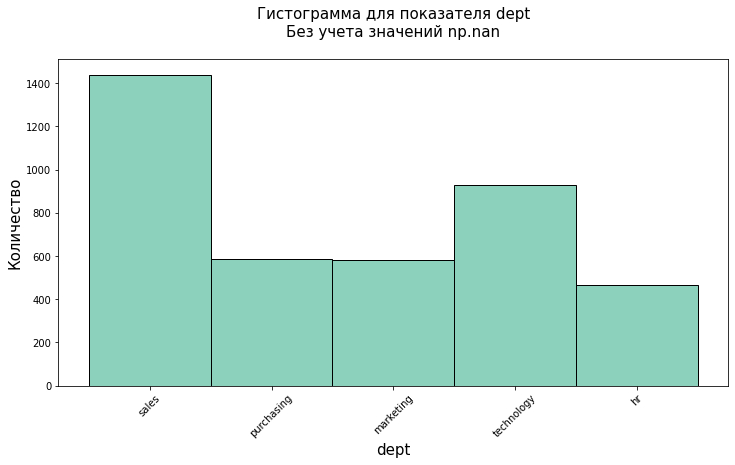

sales         0.3595
technology    0.2320
purchasing    0.1470
marketing     0.1455
hr            0.1160
Name: dept, dtype: float64
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64




In [109]:
cat_col_analiz(train_quit, 'dept')

Распределение очень близкое к соответствующему столбцу в предыдущем датасете **train_job_satisfaction_rate**.
На первом месте по количеству сотрудников - продажи, на втором технологический отдел.

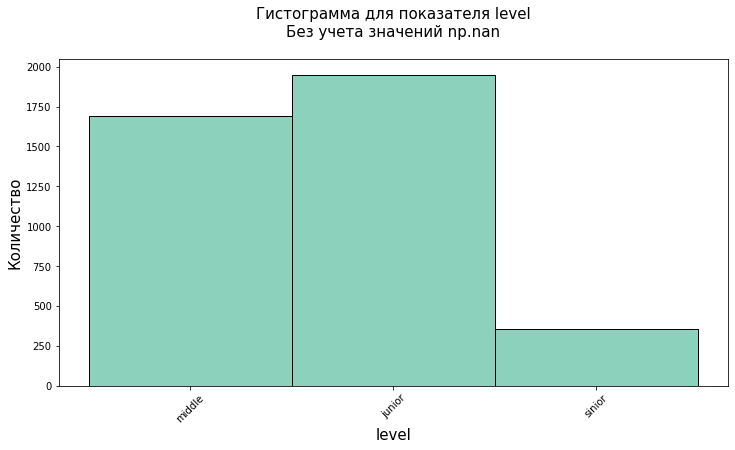

junior    0.48725
middle    0.42350
sinior    0.08925
Name: level, dtype: float64
junior    1949
middle    1694
sinior     357
Name: level, dtype: int64




In [110]:
cat_col_analiz(train_quit, 'level')

**Тоже самое справедливо и для столбца "level".**

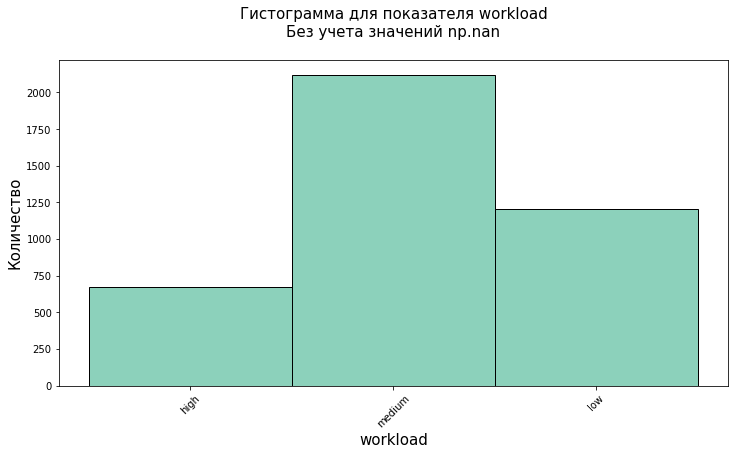

medium    0.5295
low       0.3020
high      0.1685
Name: workload, dtype: float64
medium    2118
low       1208
high       674
Name: workload, dtype: int64




In [111]:
cat_col_analiz(train_quit, 'workload')

**Аналогично**

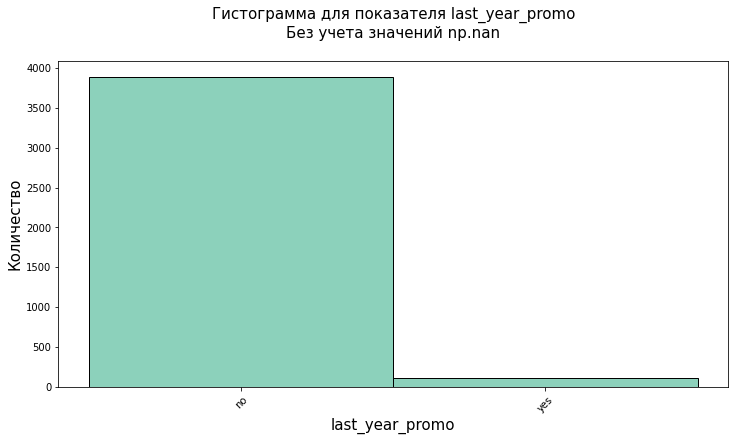

no     0.97175
yes    0.02825
Name: last_year_promo, dtype: float64
no     3887
yes     113
Name: last_year_promo, dtype: int64




In [112]:
cat_col_analiz(train_quit, 'last_year_promo')

**Аналогично**

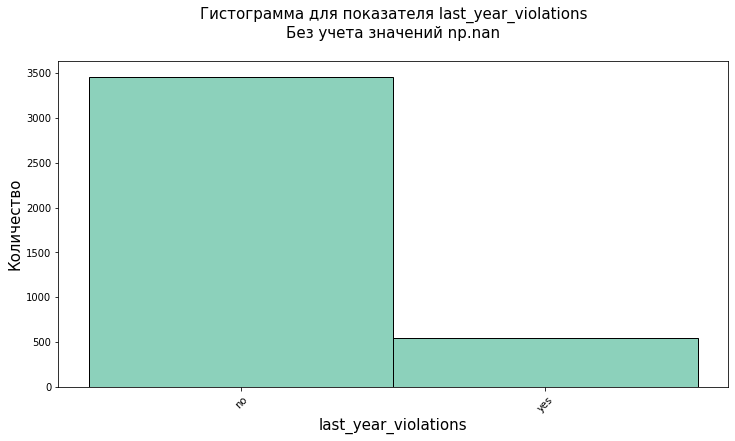

no     0.86375
yes    0.13625
Name: last_year_violations, dtype: float64
no     3455
yes     545
Name: last_year_violations, dtype: int64




In [113]:
cat_col_analiz(train_quit, 'last_year_violations')

**Аналогично**

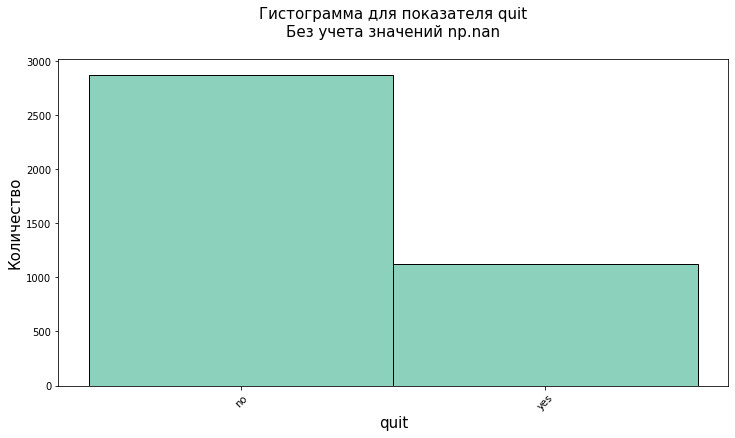

no     0.718
yes    0.282
Name: quit, dtype: float64
no     2872
yes    1128
Name: quit, dtype: int64




In [114]:
cat_col_analiz(train_quit, 'quit')

Это новый для нашего исследования столбец. 

По гистограмме видно, что 28.2% сотрудников уволились

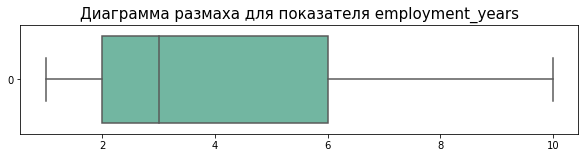

Выбросы ниже нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


Выбросы выше нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64




In [115]:
num_col_analiz(train_quit, 'employment_years')

**Аналогично** с соответствующим столбцом в датасете **train_job_satisfaction_rate**

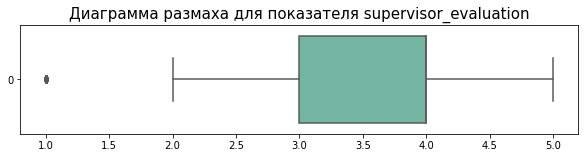

Выбросы ниже нормальных значений: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 
Количество выбросов: 202 
Процент выбросов: 5.05 %


Выбросы выше нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64




In [116]:
num_col_analiz(train_quit, 'supervisor_evaluation')

**Аналогично**, по аналогии с предыдущим датасетом, "1" за выбросы не считаем и оставляем их на месте

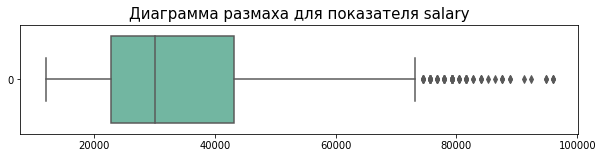

Выбросы ниже нормальных значений: [] 
Количество выбросов: 0 
Процент выбросов: 0.0 %


Выбросы выше нормальных значений: [74400, 74400, 74400, 74400, 74400, 74400, 75600, 75600, 75600, 75600, 75600, 75600, 75600, 75600, 75600, 75600, 75600, 75600, 76800, 76800, 76800, 76800, 76800, 78000, 78000, 78000, 78000, 78000, 78000, 78000, 78000, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 79200, 80400, 80400, 80400, 80400, 81600, 81600, 81600, 81600, 81600, 81600, 81600, 81600, 82800, 82800, 84000, 84000, 84000, 85200, 86400, 87600, 87600, 87600, 88800, 88800, 91200, 92400, 94800, 94800, 96000, 96000, 96000] 
Количество выбросов: 78 
Процент выбросов: 1.95 %


count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64




In [117]:
num_col_analiz(train_quit, 'salary')

**Аналогично**, по аналогии с предыдущим датасетом, "повышенные" значения зарплат за выбросы не считаем и оставляем их на месте

#### 3.2. Портрет «уволившегося сотрудника».

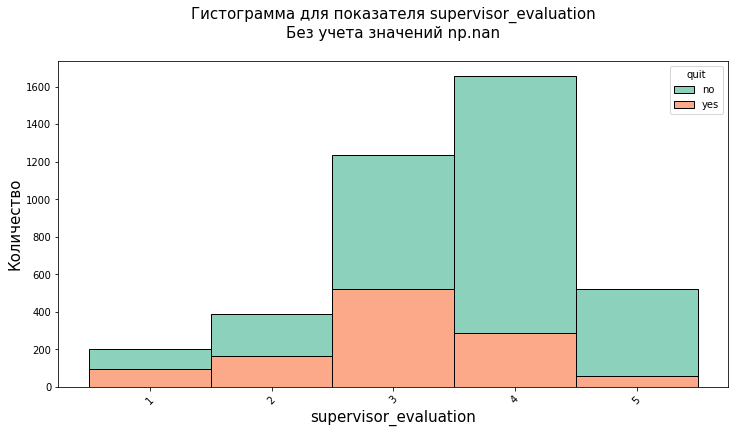

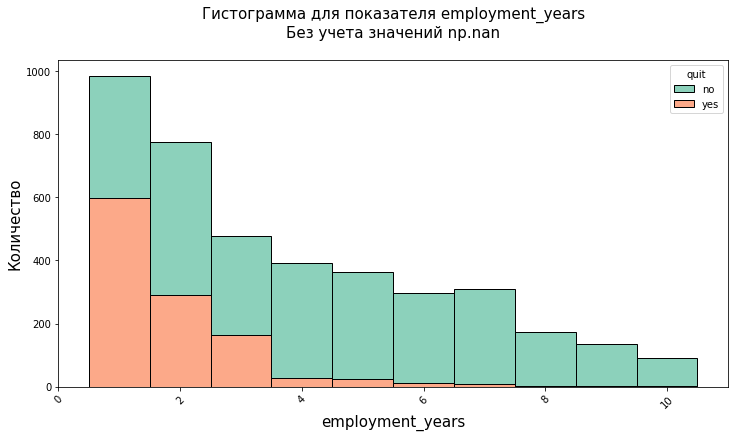

In [118]:
for col in train_quit[['supervisor_evaluation','employment_years']]:
    cat_col_analiz(train_quit, col=col, hue='quit', val_show='off', discrete=True, common_norm=True)

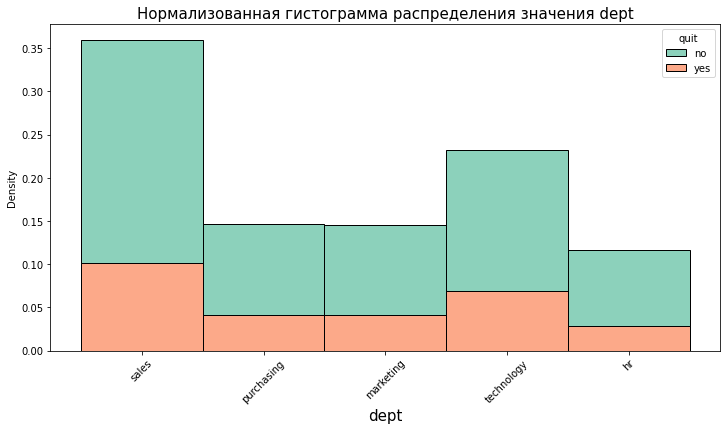

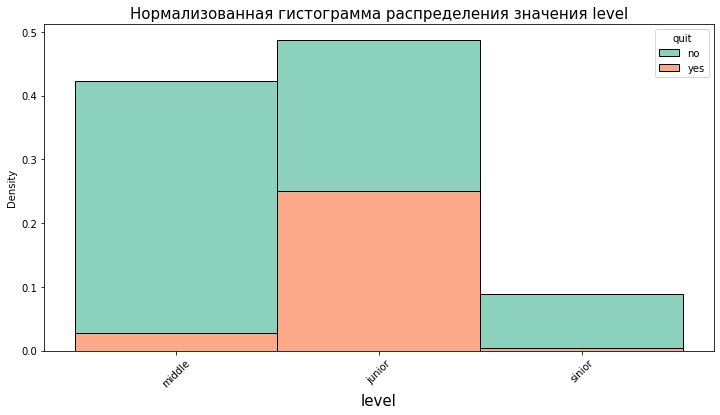

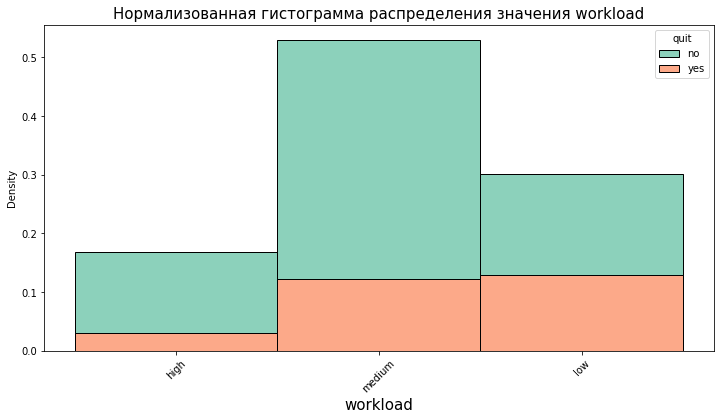

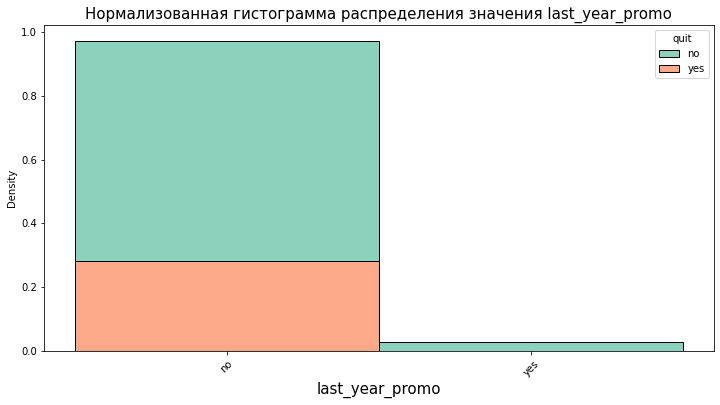

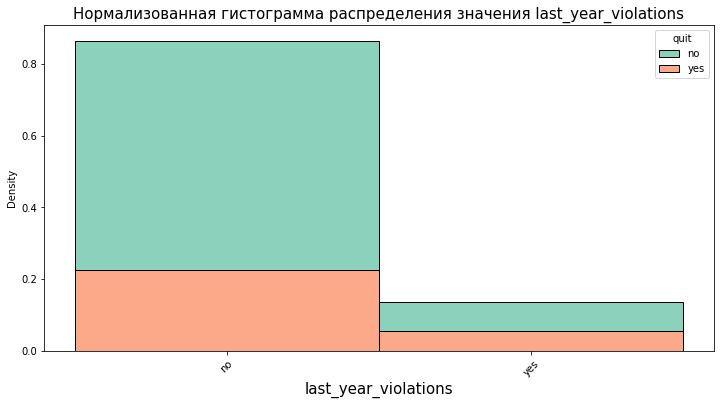

In [119]:
for col in train_quit.drop(['id','quit','supervisor_evaluation','employment_years','salary'], axis=1).columns:
    sn.set_palette('Set2')
    plt.subplots(figsize=(12, 6))
    sn.histplot(data=train_quit, x=col, hue='quit', multiple='stack', stat="density", common_norm=True);
    plt.title(label=f'Нормализованная гистограмма распределения значения {col}' , fontsize=15)
    plt.xlabel(col, fontsize=15)
    plt.xticks(rotation=45,fontsize=10)
    plt.show()

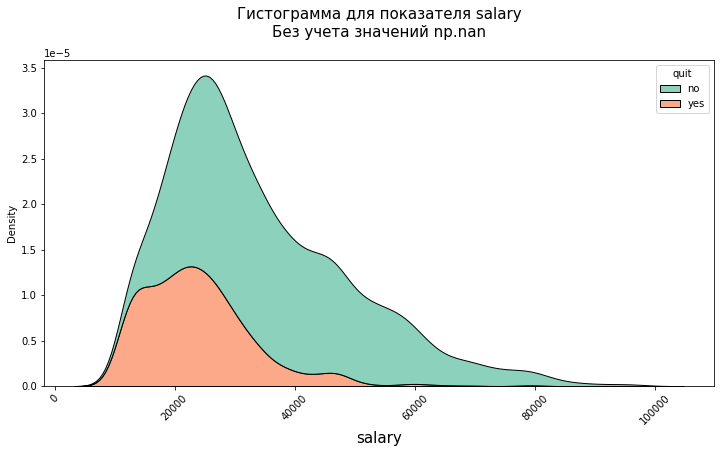

In [120]:
sn.set_palette('Set2')
plt.subplots(figsize=(12, 6))
sn.kdeplot(data=train_quit, x='salary', hue='quit', multiple='stack');
plt.title(label = f'Гистограмма для показателя salary\nБез учета значений np.nan\n', fontsize=15)
plt.xlabel('salary', fontsize=15)
plt.xticks(rotation=45,fontsize=10)
plt.show()

##### Промежуточный вывод по портрету "уволившегося сотрудника"

Как говориться, без неожиданностей.

* **По рабочему отделу**
Четкой корреляции не видно, по графику можно сказать, что сотрудники увольняются из всех отделов примерно в равной пропорции


* **Уровню должности или "level"**
Тут на графике видно четкую корреляцию, чем выше должность, тем меньше увольнений. Логично, что сотрудники с высокой должностью и следовательно бОльшим окладом, охотнее продолжают свою карьеру на текущем месте


* **По уровню нагрузки или "workload"**
По графику похоже, что чем ниже нагрузка, тем выше в процентном отношении шанс увольнения. Можно предположить, что низкая нагрузка подразумевает мЕньшую ответственность и нижестоящую должность, а там текучка обычно выше, чем на более высоких должностях \ нагрузках. 


* **По показателю "employment_years"**
На графике прослеживается четкая корреляция, чем "новее" сотрудник, тем чаще он увольняется.


* **По показателю last_year_promo**
Так же прослеживается четкая корреляция, сотрудники получившие повышение не увольняются


* **По показателю last_year_violations**
Видна корреляция, сотрудники нарушающие трудовой распорядок увольняются чаще


* **По показателю supervisor_evaluation**
Тут можно смело утверждать, что чем выше оценка качества работы сотрудника, тем реже такие увольняются.


* **По показателю salary**
Тут тоже без неожиданностей, высокая корреляция, чем меньше з\п, тем выше шанс ухода сотрудника.



**Какой портрет можно составить для среднестатистического "уволившегося сотрудника"?**


**Скорее всего это:** 
* совсем новый для компании сотрудник со стажем до года,
* независимо от департамента,
* занимает должность уровня junior,
* с низкой рабочей загрузкой,
* допускающий нарушения трудового распорядка,
* не получавший повышения
* с оценкой качества его работы около 3
* с низкой заработной платой

#### 3.3 Визуализация и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников.
_**Используйте данные с обоими целевыми признаками тестовой выборки.**_

**Тестовые целевые выборки это _test_target_job_satisfaction_rate_ и _test_target_quit_**

In [121]:
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.sort_index()

In [122]:
print(test_target_job_satisfaction_rate.index.equals(test_target_quit.index))

True


ID сотрудников совпадают в обоих датасетах с тестовой целевой выборкой.

Обьеденим их для анализа в единый датасет и посмотрим на распределение.

In [123]:
satisfaction_quit = test_target_job_satisfaction_rate.join(test_target_quit)

In [124]:
satisfaction_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 100298 to 999029
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
 1   quit                   2000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 111.4+ KB


In [125]:
satisfaction_quit.head()

,job_satisfaction_rate,quit
id,,
100298,0.80,no
100480,0.84,no
100503,0.79,no
100610,0.75,no
100692,0.69,no


объединение прошло успешно

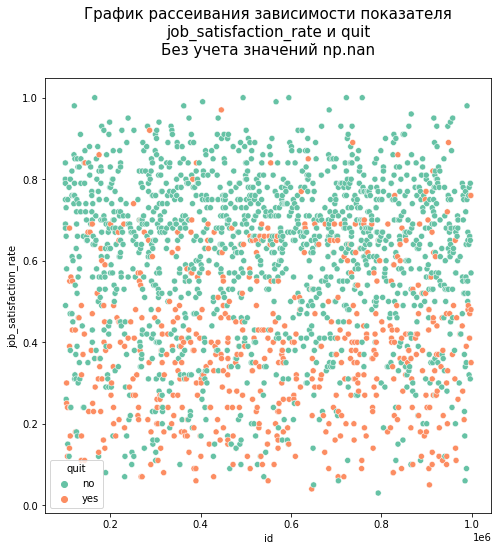

In [126]:
plt.subplots(figsize=(8, 8))
sn.scatterplot(data=satisfaction_quit, x='id' ,y='job_satisfaction_rate', hue='quit');
plt.title(label = f'График рассеивания зависимости показателя\njob_satisfaction_rate и quit\nБез учета значений np.nan\n', fontsize=15);

Заметно, что зеленые отметки (quit-no) плотнее сгрупированны после оценки удовлетворенности выше 0.6, а красные наоборот резко сокращают свое присутствие выше 0.7.


Следовательно мы наблюдаем корреляцию описывающую следующее, сотрудники с оценкой удовлетворенности выше 0.6-0.7 намного реже увольняются с работы. 

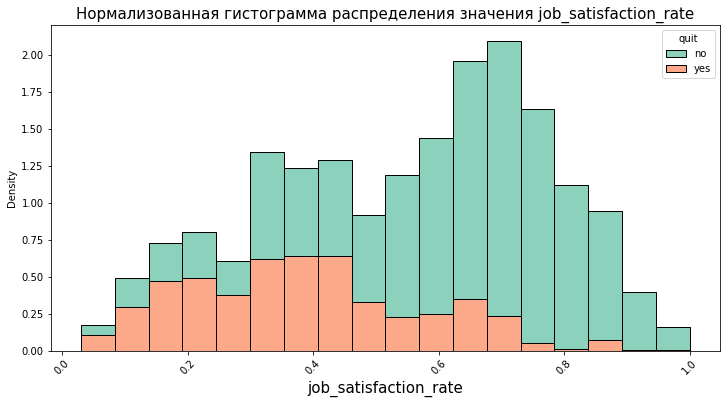

In [127]:
sn.set_palette('Set2')
plt.subplots(figsize=(12, 6))
sn.histplot(data=satisfaction_quit, x='job_satisfaction_rate', hue='quit', multiple='stack', stat='density', common_norm=True);
plt.title(label=f'Нормализованная гистограмма распределения значения job_satisfaction_rate' , fontsize=15)
plt.xlabel('job_satisfaction_rate', fontsize=15)
plt.xticks(rotation=45,fontsize=10)
plt.show()

### Шаг 4. Добавление нового входного признака

In [128]:
train_quit = train_quit.set_index('id')

In [129]:
train_quit = train_quit.sort_index()

In [130]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes
100459,purchasing,junior,medium,3,no,no,3,21600,yes
100469,marketing,junior,medium,1,no,no,4,28800,no
100601,technology,middle,high,4,no,no,4,68400,no
100858,sales,junior,medium,2,no,no,4,25200,yes


In [131]:
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [132]:
test_target_quit.head()

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


In [133]:
y_test.head()

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


Так как нам надо обучить вторую модель с учетом нового входящего признака **job_satisfaction_rate**, но у новой тренировочной выборки **train_quit** другие ID сотрудников, то чтобы добавить в тренировочную выборку новый признак, нам придется его создать из результата первой модели, который она даст после обработки **train_quit** датасета

In [134]:
y_pred_rate_for_training = grid_search.best_estimator_.predict(train_quit.drop('quit', axis=1))

In [135]:
train_quit['job_satisfaction_rate'] = y_pred_rate_for_training

In [136]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes,0.336000
100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.340000
100469,marketing,junior,medium,1,no,no,4,28800,no,0.655000
100601,technology,middle,high,4,no,no,4,68400,no,0.677059
100858,sales,junior,medium,2,no,no,4,25200,yes,0.823636


Теперь у нас есть **тренировочные данные** для второй модели с новой фичей внутри

**--------------------------------------------**

Осталось добавить новую фичу в **тестовые данные** **test_features**.
Мы можем в них добавить как результат работы первой модели **y_pred**, или тестовый целевой признак **test_target_job_satisfaction_rate**


Принимая во внимание, что y_pred все же только предположение с известной долей ошибок, а test_target_job_satisfaction_rate истинные значения признака **job_satisfaction_rate** для **test_features**, то предлагаю добавить именно их в общетестовый датасет

In [137]:
test_features = test_features.sort_index()

In [138]:
job_satisfaction_rate_for_test_features = grid_search.best_estimator_.predict(test_features)

In [139]:
test_features['job_satisfaction_rate'] = job_satisfaction_rate_for_test_features

In [140]:
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.841875
100480,marketing,junior,low,4,no,no,4,16800,0.850000
100503,purchasing,middle,high,5,no,no,4,55200,0.769333
100610,sales,middle,medium,5,no,no,4,43200,0.815000
100692,sales,middle,high,6,no,no,4,48000,0.700000


**тестовый "X_test" датасет готов**

### Шаг 5. Подготовка данных

In [141]:
X_train_2 = train_quit.drop('quit', axis = 1)
y_train_2 = train_quit['quit']
X_test_2 = test_features
y_test_2 = test_target_quit

У нас уже есть списки входящих признаков, разбитых по категориям, к ним добавился только 1 новый признак - job_satisfaction_rate

In [142]:
ohe_col_2 = ['dept', 'last_year_promo', 'last_year_violations']
ord_col_2 = ['level', 'workload']
pass_col_2 = ['supervisor_evaluation', 'employment_years']
num_col_2 = ['salary','job_satisfaction_rate']

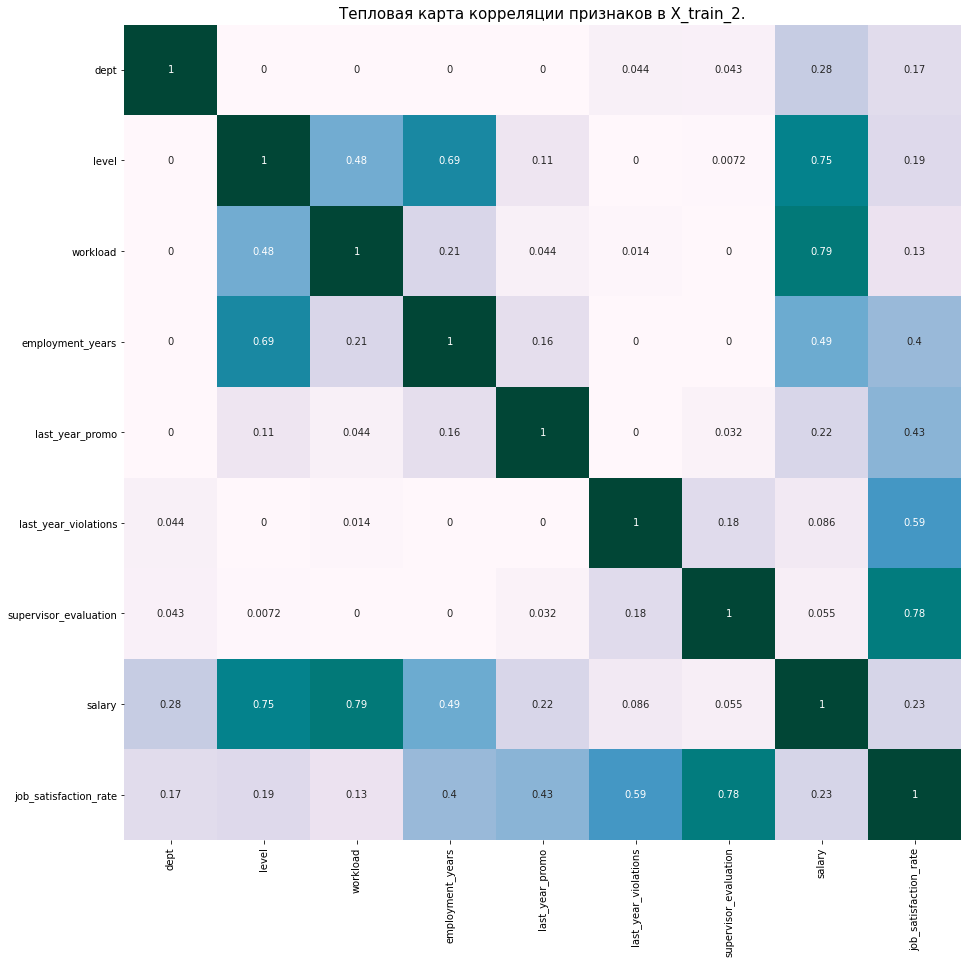

In [143]:
plt.subplots(figsize=(15, 15))
plt.title(label = 'Тепловая карта корреляции признаков в X_train_2.', fontsize=15)
sn.heatmap(X_train_2.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), cmap="PuBuGn", cbar=False, annot=True);

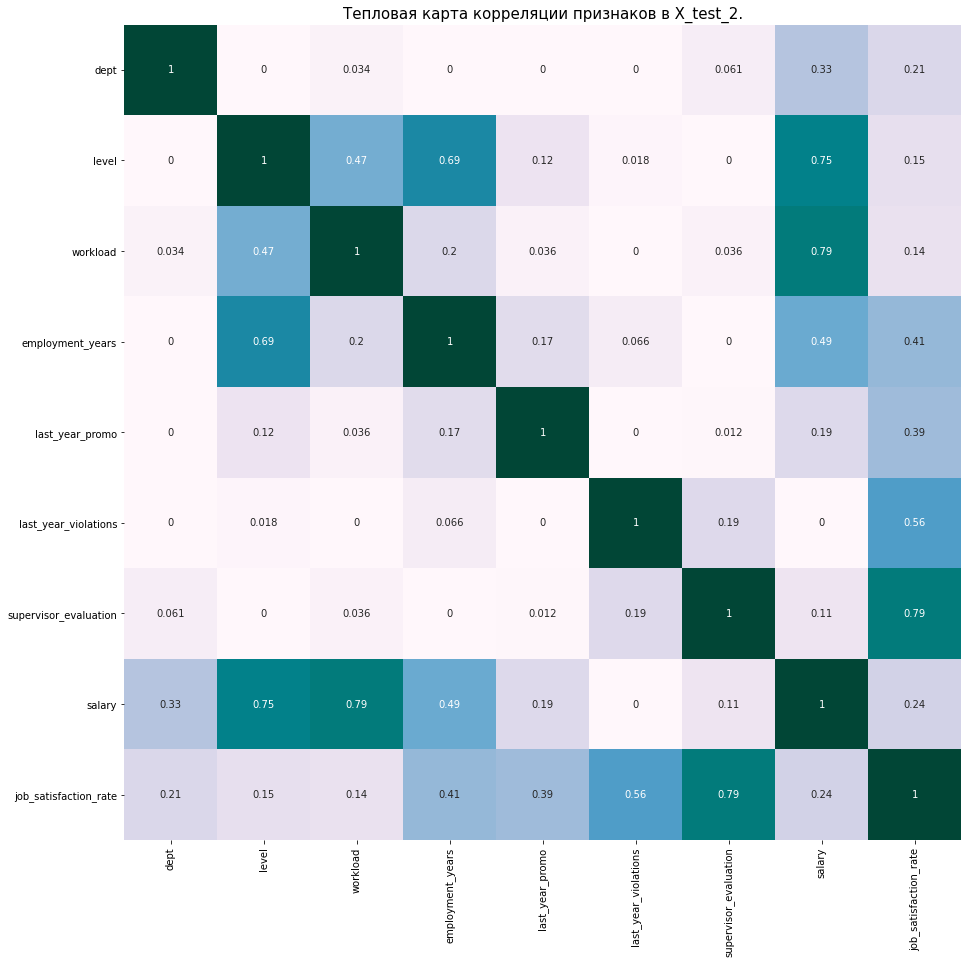

In [144]:
plt.subplots(figsize=(15, 15))
plt.title(label = 'Тепловая карта корреляции признаков в X_test_2.', fontsize=15)
sn.heatmap(X_test_2.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), cmap="PuBuGn", cbar=False, annot=True);

Мультиколинеарности не обнаружено

### Шаг 6. Обучение модели

In [145]:
ohe_pipe_2 = Pipeline(
    [
        (
            'simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', OneHotEncoder(handle_unknown='error', drop='first')
        )
    ]
)

In [146]:
ord_pipe_2 = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                handle_unknown='use_encoded_value',
                unknown_value=np.nan,
                categories=[
                    ['junior','middle','sinior'],
                    ['low','medium','high']
                ]
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [147]:
data_preprocessor_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe_2, ohe_col_2),
        ('ord', ord_pipe_2, ord_col_2),
        ('pas', 'passthrough', pass_col_2),
        ('num', StandardScaler(), num_col_2)
    ],
    remainder='passthrough'
)

In [148]:
pipe_final_2 = Pipeline(
    [
        ('preprocessor', data_preprocessor_2),
        ('models', None)
    ]
) 

In [149]:
param_grid_2 = [
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5,15),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [150]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_distributions=param_grid_2,
    cv=5,
    scoring = 'roc_auc', 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)

In [151]:
grid_search_2 = GridSearchCV(
    pipe_final_2, 
    param_grid_2,
    cv=10,
    scoring = 'roc_auc',  
    n_jobs=-1
)

In [152]:
randomized_search_2.fit(X_train_2, y_train_2);

In [153]:
grid_search_2.fit(X_train_2, y_train_2);

In [154]:
print ('Метрика лучшей модели на кроссвалидации:', randomized_search_2.best_score_)

Метрика лучшей модели на кроссвалидации: 0.9171045368709315


In [155]:
print ('Метрика лучшей модели на кроссвалидации:', grid_search_2.best_score_)

Метрика лучшей модели на кроссвалидации: 0.9210138953041692


Теперь для проверим качество модели на тестовых данных. Критерий успеха: ROC_AUC >= 0.91

In [156]:
y_proba_2 = randomized_search_2.best_estimator_.predict_proba(X_test_2)[:,1]

In [157]:
y_pred_2 = randomized_search_2.best_estimator_.predict(X_test_2)

In [158]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_2, y_proba_2)}')

Метрика ROC-AUC на тестовой выборке: 0.9019754193089551


In [159]:
y_proba_2_grid = grid_search_2.best_estimator_.predict_proba(X_test_2)[:,1]

In [160]:
y_pred_2_grid = grid_search_2.best_estimator_.predict(X_test_2)

In [161]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_2, y_proba_2_grid)}')

Метрика ROC-AUC на тестовой выборке: 0.9114783974396966


**Критерий достигнут**

Добавим прогноз модели к тестовой выборке

In [162]:
test_features['leave'] = y_pred_2_grid

In [163]:
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,leave
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.841875,no
100480,marketing,junior,low,4,no,no,4,16800,0.850000,no
100503,purchasing,middle,high,5,no,no,4,55200,0.769333,no
100610,sales,middle,medium,5,no,no,4,43200,0.815000,no
100692,sales,middle,high,6,no,no,4,48000,0.700000,no


**Проведем анализ важности признаков для заказчика**

In [164]:
X_test_2_shap = randomized_search_2.best_estimator_.named_steps['preprocessor'].transform(X_test_2.drop('leave', axis=1))

In [165]:
explainer = shap.LinearExplainer(randomized_search_2.best_estimator_['models'], X_test_2_shap)

In [166]:
ohe_c = randomized_search_2.best_estimator_.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
ord_c = randomized_search_2.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()
pass_c = randomized_search_2.best_estimator_.named_steps['preprocessor'].transformers_[2][1].get_feature_names_out()
num_c = randomized_search_2.best_estimator_.named_steps['preprocessor'].transformers_[3][1].get_feature_names_out()

In [167]:
feature_names = np.concatenate([ohe_c,ord_c,pass_c,num_c])

In [168]:
explainer.feature_names = feature_names

In [169]:
shap_values = explainer(X_test_2_shap)

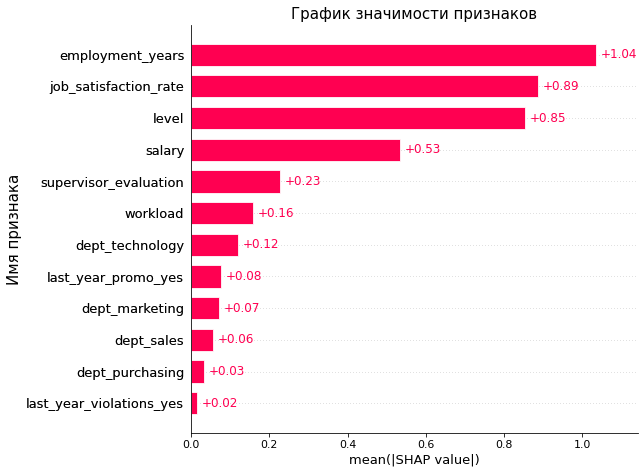

In [170]:
plt.subplots(figsize=(12, 6))
plt.title(label='График значимости признаков' , fontsize=15)
plt.xlabel('shap_value или значимость', fontsize=15)
plt.ylabel('Имя признака', fontsize=15)
shap.plots.bar(shap_values, max_display=20)
plt.show()

### Шаг 7. Выводы

In [171]:
print(randomized_search_2.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent...
                                                                 

Лучше всего справилась модель логистической регрессии с параметрами C=2, penalty='l1', random_state=42, solver='liblinear'

Она выйграла у других моделей, т.к показывает высокую точность в задачах классификации, когда количество классов не велико. В данной задаче их было всего 2.

### Общий вывод

##### Задача

Заказчик - HR-аналитики компании «Работа с заботой». Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Требовалось выполнить 2 задачи:

* Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
* Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

##### Этапы работы

* Изучение предоставленных данных


* Загрузка данных в датасеты


* Предобработка данных (чать работы в пайплайне)
    * Исправление названий столбцов
    * Приведение написания данных к единому стандарту
    * Заполнение пропусков
    * Удаление дубликатов
    * Изменение типов данных
    
    
* Исследовательский анализ данных
    * Поиск и удаление выбросов
    * Изучение распределения данных


* Подготовка данных (часть работы в пайлайне)


* Обучение моделей


* Выводы по задачам

##### Предложения для бизнеса

Что мы можем посоветовать бизнесу по результатам нашего исследования. Так как финальная задача, и главный интерес бизнеса был предсказать отток сотрудника, мы можем посоветовать только как его удержать, и рассказать какие критерии влияют на вероятность сотрудника уволиться.

Из результата работы модели, мы выяснили, что 4 самых весомых признака, влияющие на решение работника остаться или нет, это в порядке убывания важности:
* employment_years
* job_satisfaction_rate
* level
* salary

В свою очередь, второй по значимости признак job_satisfaction_rate , как мы знаем из исследования выводом первой задачи, складывается в основном из supervisor_evaluation и salary.

Что мы можем в итоге сказать, такие признаки как "employment_years" и "level" косвенно зависят от действия работодателя. Тк он не может заставить сотрудника остаться и накопить много лет стажа, или назначить на высокую должность сотрудника, который не дотягивает до нее по своей компеценции.

Но такие как **supervisor_evaluation** и **salary** уже больше зависят от руководства.

Следовательно рекомендация для удержания сотрудников такая: чаще хвалить, и больше платить!:)